## Clay Minerals

### 1. Data Analysis

In [ ]:
import datetime as dt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
# from scipy.stats import mannwhitneyu, ttest_ind

In [ ]:
# use science style 
plt.style.use(['science', 'no-latex', 'russian-font'])

sns.set_palette('colorblind')
# sns.set_context('talk')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size':16})

Text(0, 0.5, 'Function Values')

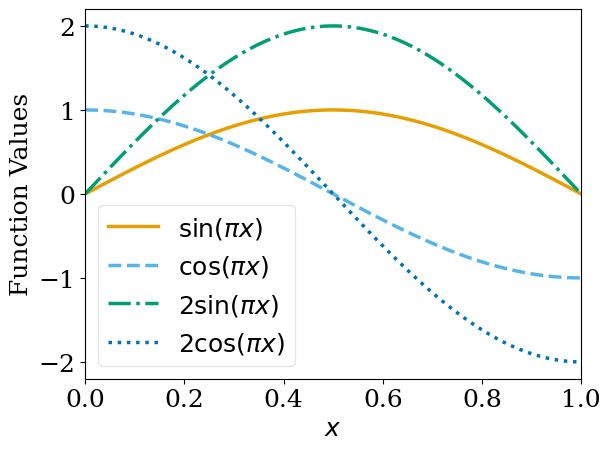

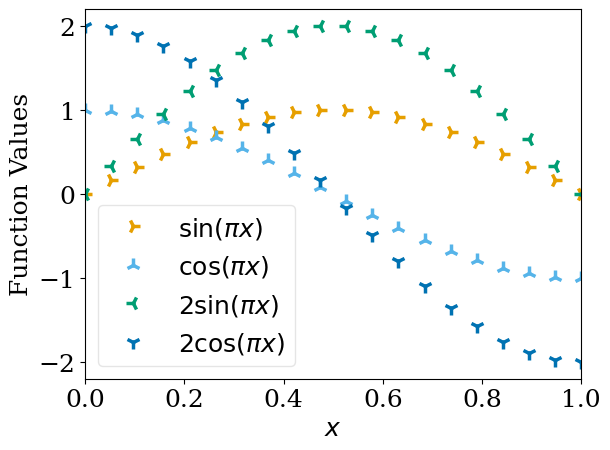

In [ ]:
# !/usr/bin/python3

import matplotlib.pyplot as plt

# line cyclers adapted to colourblind people
from cycler import cycler
line_cycler  = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))

# matplotlib's standard cycler
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])

plt.rc("axes", prop_cycle=line_cycler)

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{newpxtext}\usepackage{newpxmath}\usepackage{commath}\usepackage{mathtools}")
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)


import os
# directory = os.path.dirname(os.path.abspath(__file__))


# plots
# plt.close("all")

import numpy as np
x = np.linspace(0., 1., 200)

plt.rc("axes", prop_cycle=line_cycler)
plt.figure()
plt.plot(x,   np.sin(np.pi*x), label="$\sin(\pi x)$")
plt.plot(x,   np.cos(np.pi*x), label="$\cos(\pi x)$")
plt.plot(x, 2*np.sin(np.pi*x), label="$2 \sin(\pi x)$")
plt.plot(x, 2*np.cos(np.pi*x), label="$2 \cos(\pi x)$")
plt.legend()
plt.xlabel("$x$")
plt.xlim(x[0], x[-1])
plt.ylabel("Function Values")
# plt.savefig(os.path.join(directory, "line_plot_python.png"), bbox_inches="tight")

import numpy as np
x = np.linspace(0., 1., 20)

plt.rc("axes", prop_cycle=marker_cycler)
plt.figure()
plt.plot(x,   np.sin(np.pi*x), label="$\sin(\pi x)$")
plt.plot(x,   np.cos(np.pi*x), label="$\cos(\pi x)$")
plt.plot(x, 2*np.sin(np.pi*x), label="$2 \sin(\pi x)$")
plt.plot(x, 2*np.cos(np.pi*x), label="$2 \cos(\pi x)$")
plt.legend()
plt.xlabel("$x$")
plt.xlim(x[0], x[-1])
plt.ylabel("Function Values")
# plt.savefig(os.path.join(directory, "marker_plot_python.png"), bbox_inches="tight")


In [ ]:
def removeNoize(x: float, 
                acid: str,
                element: str,
               df_control: pd.DataFrame)-> float:
    """
    remove background values for each acid
    
    x: float - value in mmol/l without correction
    acid: str - kind of acid 
    element: str - element to correct
    df_control: pd.DataFrame - df with values for acids
    
    return float: corrected value
    """
    
    mask = df_control['parameter']==acid
    select = df_control.loc[mask, element]
    if len(select) == 0:
        print(acid, element)
    return x - select.values[0]

In [ ]:
# Read initial dataset
df = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ICP')


# masses for elements in analysis
dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['parameter', 'days', 'kind', 'code', 
        'Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
df = df[cols]


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, key]/value
    
mask = df['kind']=='control'
df_control = df.loc[mask].copy()
df = df.loc[~mask].copy()
df = df.reset_index(drop=True)


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, ['parameter', key]].apply(lambda x: removeNoize(x[key], 
                                                                         x['parameter'], 
                                                                         element=key,
                                                                     df_control=df_control), axis=1)

In [ ]:
base_concetration = {"ratio_Mg_to_Si": 2.64/3.04, 
                    "ratio_Ca_to_Si": .11/3.04, 
                    "ratio_Fe_to_Si": 0.27/3.04, 
                    "ratio_Al_to_Si": 0.99/3.04,
                    "ratio_K_to_Si": 0.67/3.04,
                    "ratio_K_to_Mg": 0.67/2.64}

In [ ]:
for element in ['Al', 'Ca', 'Fe', 'K', 'Mg']:
    df.loc[:, f'ratio_{element}_to_Si'] = df[element]/df['Si']    

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/585865106.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


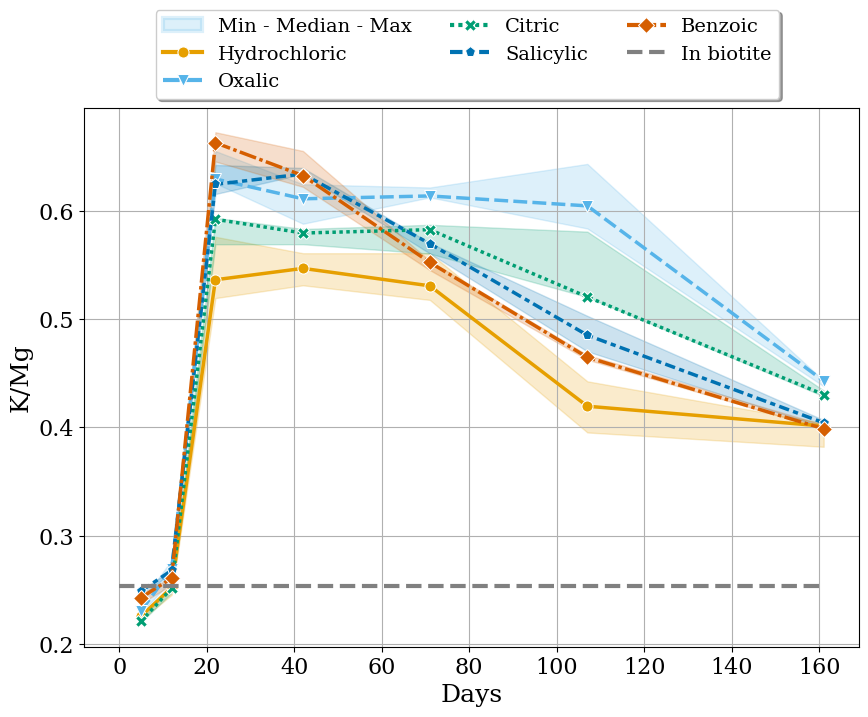

In [ ]:
folder = '../plots/acid_elements/'
df.loc[:, f'ratio_K_to_Mg'] = df['K']/df['Mg']
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_prop_cycle(line_cycler)
ax.set_prop_cycle(marker_cycler)
sns.lineplot(x='days',
             y='ratio_K_to_Mg',
             markersize=8, 
             data=df, 
             markers=["o", "v", 'X', "p", 'D'],
             errorbar=lambda x: (x.min(), x.max()),
             estimator='median',
             style = 'parameter', 
             hue='parameter',
             ax=ax
            )

ax.grid()
ax.collections[1].set_label('Min - Median - Max')
ax.hlines(y=base_concetration['ratio_K_to_Mg'], xmin=0, xmax=161, 
          linestyles='dashed', 
          label = 'In biotite', 
         linewidth=3, 
         color='grey', )
leg=ax.legend(frameon=True,           
           bbox_to_anchor=(0.91, 1.2),
           fontsize=14,  
           ncol=3,
           shadow=True,)
ax.set_ylabel('K/Mg')
ax.set_xlabel('Days')
for i in leg.legendHandles:
    i.set_linewidth(3)
fname = os.path.join(folder, 'K_ratio_Mg.png')
plt.savefig(fname,  dpi=300)
plt.show()

In [ ]:
acid_namer = {'Hydrochloric': 'HCl', 
              'Oxalic':'Щавелевая', 
              'Citric':'Лимонная', 
              'Salicylic': 'Салициловая', 
              'Benzoic': 'Бензойная'}

df['parameter_ru'] = df['parameter'].apply(lambda x: acid_namer[x])

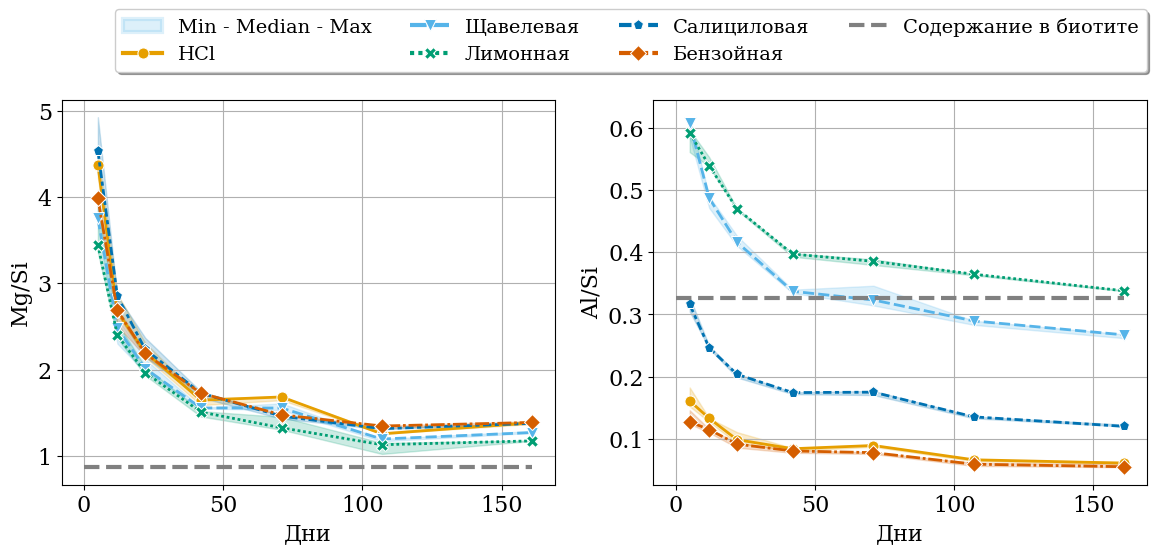

In [ ]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
font_size = 16
plt.rc('axes', titlesize=font_size)
plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
folder = '../plots/acid_elements/'
# ratios=['ratio_Al_to_Si', 'ratio_Ca_to_Si', 'ratio_Fe_to_Si', 'ratio_K_to_Si','ratio_Mg_to_Si']
ratios=['ratio_Mg_to_Si','ratio_Al_to_Si']
annots = ['A','Б']
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes=axes.flatten()
for i, element in enumerate(ratios):
    ax=axes[i]
    # fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=element,
                 marker='o',
                 markersize=8, 
                 data=df, 
                 markers=["o", "v", 'X', "p", 'D'],
                 errorbar=lambda x: (x.min(), x.max()),
                 estimator='median',
                 style = 'parameter_ru', 
                 linewidth = 2,
                 hue='parameter_ru',
                 ax=ax
                )
    
    ax.grid()
    ax.collections[1].set_label('Min - Median - Max')
    ax.hlines(y=base_concetration[element], xmin=0, xmax=161, 
              linestyles='dashed', 
              label = 'Содержание в биотите',# In biotite 
             linewidth=3, 
             color='grey', )
    if i==1:
        leg=ax.legend(frameon=True,           
                   bbox_to_anchor=(1.02, 1.26),
                   fontsize=14,  
                   ncol=4,
                   shadow=True,)
        for j in leg.legend_handles:
            j.set_linewidth(3)
    else:
        ax.get_legend().remove()

    naming = element.split('_')[1] + '/' + element.split('_')[3]
    ax.set_ylabel(naming, fontsize=font_size)
    ax.set_xlabel('Дни', fontsize=font_size)
    # fname = os.path.join(folder, element+'_ru.png')
# plt.tight_layout()
fname = os.path.join(folder, 'Al_Mg_ru_thesis.png')
plt.savefig(fname,  dpi=300)
# plt.show()

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


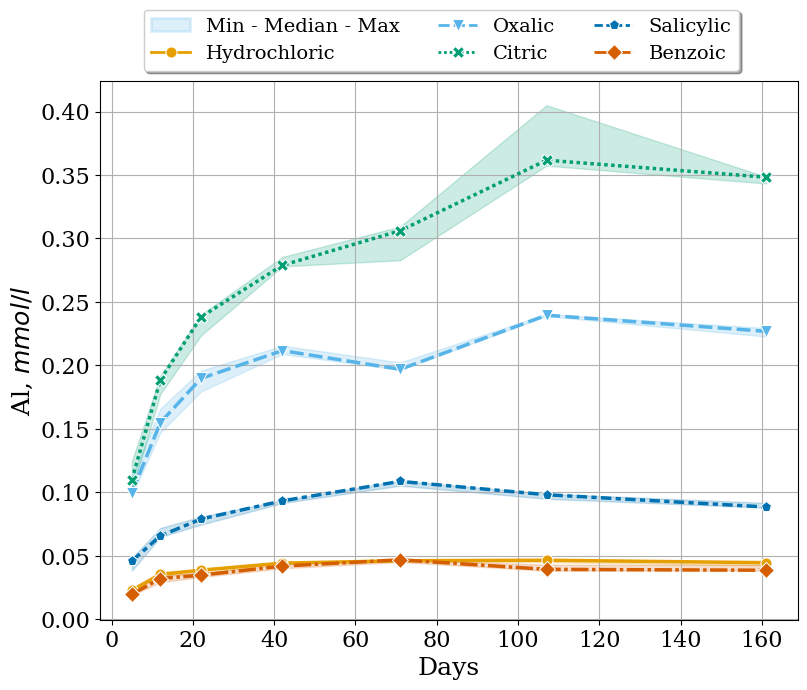

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


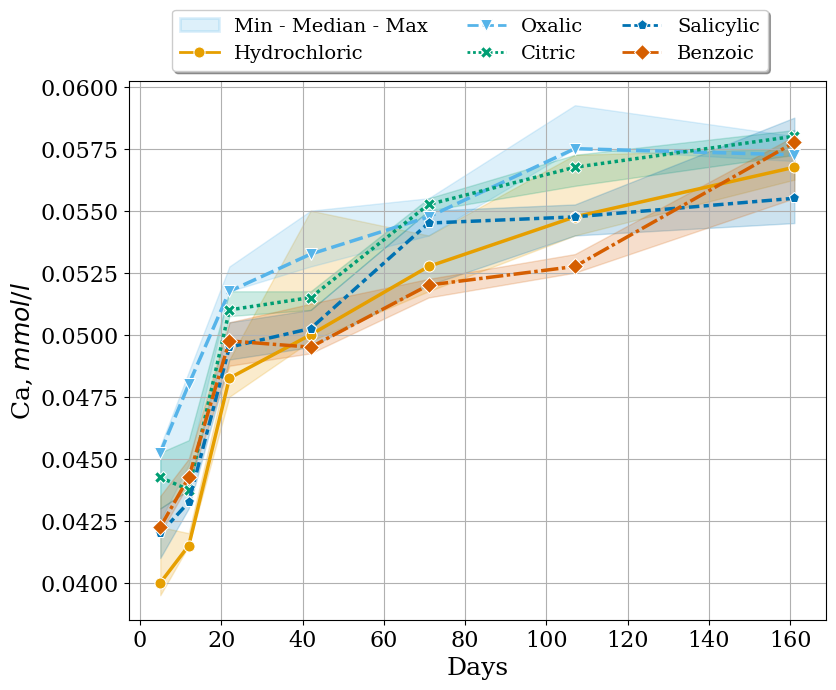

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


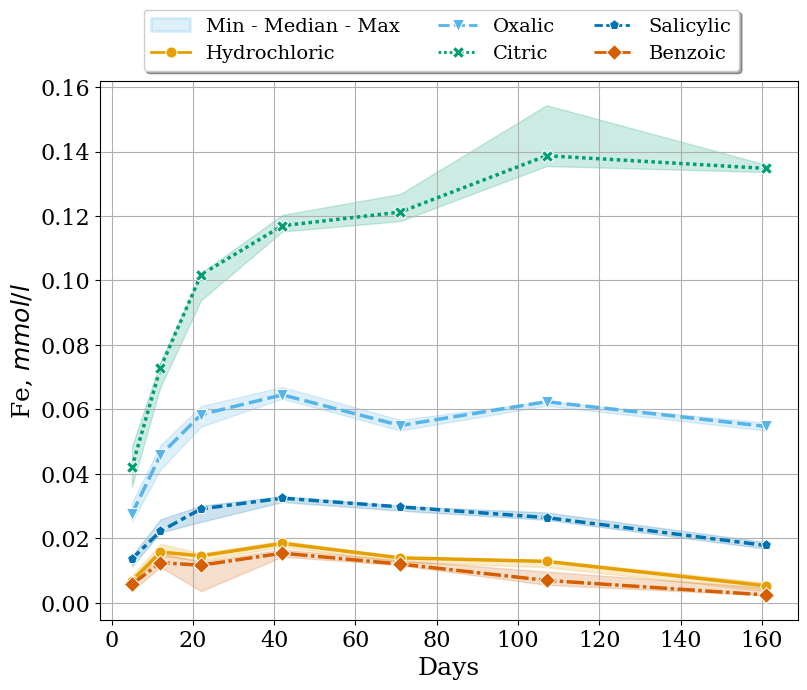

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


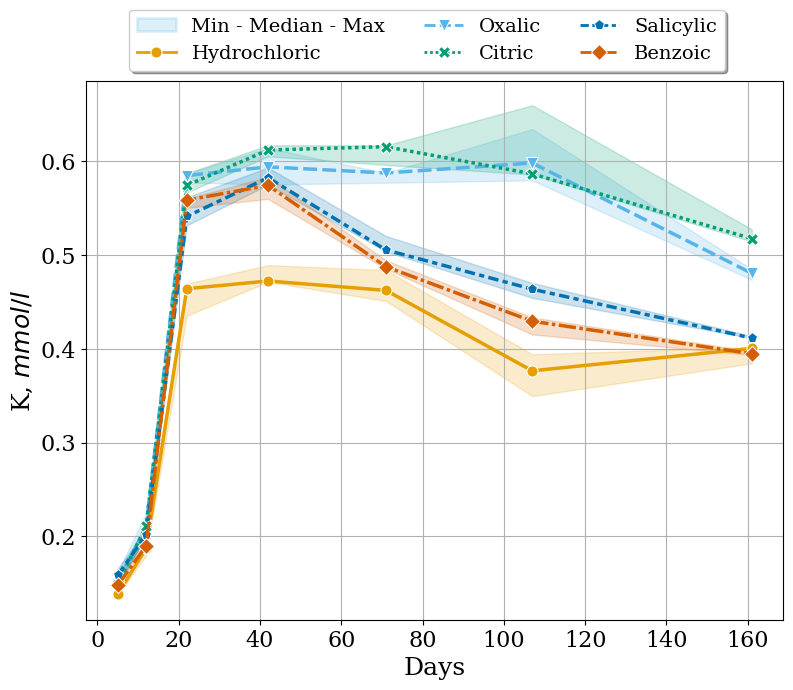

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


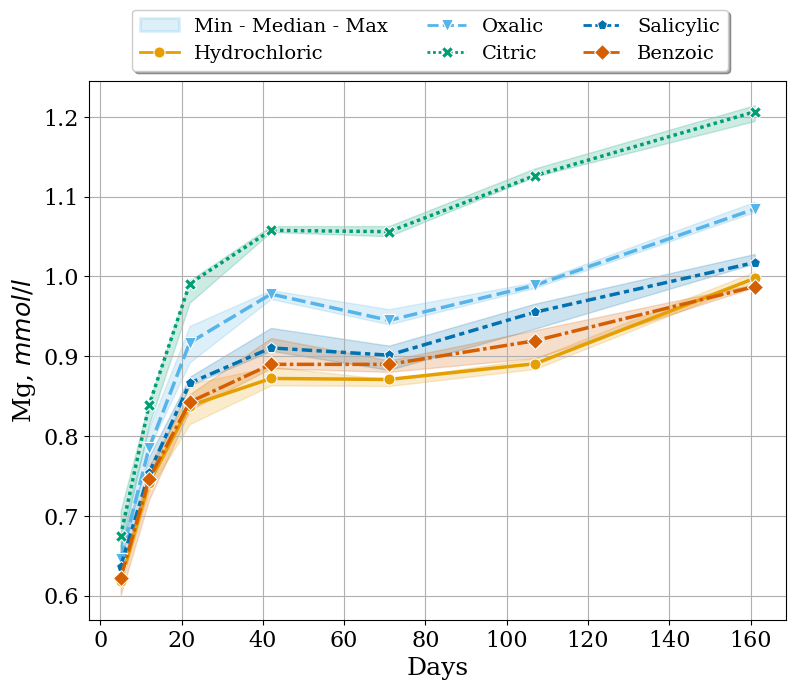

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/3564547318.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


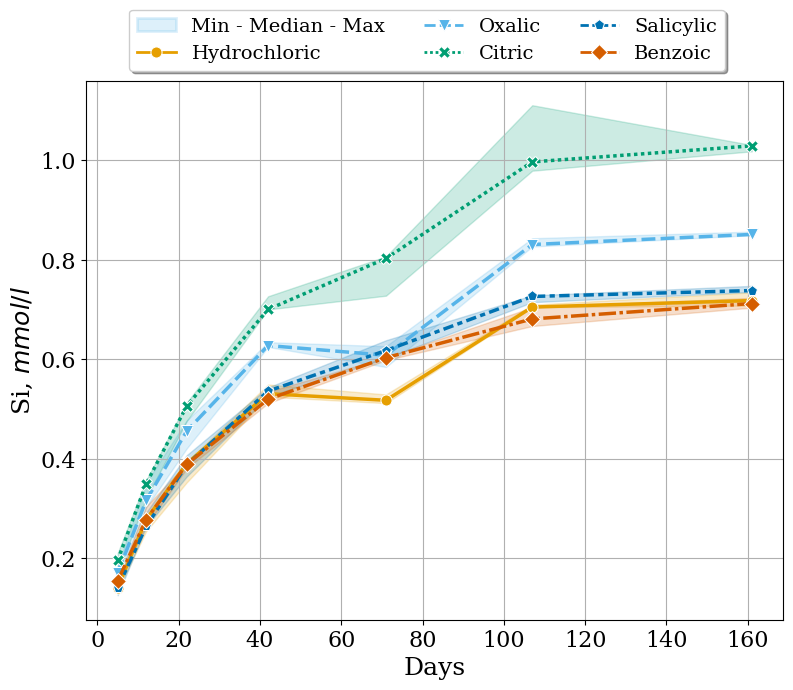

In [ ]:
folder = '../plots/acid_elements/'
elements=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
for i, element in enumerate(elements):
    fig, ax = plt.subplots(1,1, figsize=(9,7))
    sns.lineplot(x='days',
                 y=element,
                 markersize=8, 
                 data=df, 
                 markers=["o", "v", 'X', "p", 'D'],
                 errorbar=lambda x: (x.min(), x.max()),
                 estimator='median',
                 style = 'parameter', 
                 linewidth = 2.5,
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('Min - Median - Max')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.93, 1.15),
               fontsize=14,  
               ncol=3,
               shadow=True,)
    
    ax.set_ylabel(element+', $mmol/l$')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(2)
    fname = os.path.join(folder, element+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [ ]:
df_melted = pd.melt(df, id_vars= ['parameter', 'days', 'kind'],
        value_vars=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si'])

In [ ]:
mask = df_melted['days']==161
bar_df = df_melted.loc[mask]

<Axes: xlabel='days', ylabel='value'>

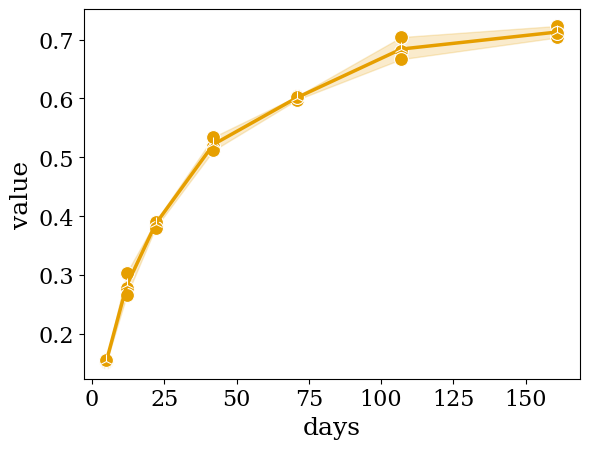

In [ ]:
sns.lineplot(x='days', y='value', data=df_melted.loc[mask])
sns.scatterplot(x='days', y='value', data=df_melted.loc[mask])

In [ ]:
# df_melted.to_csv('../data/dataset.csv')

In [ ]:
# df_melted=pd.read_csv('../data/dataset.csv', index_col=0)

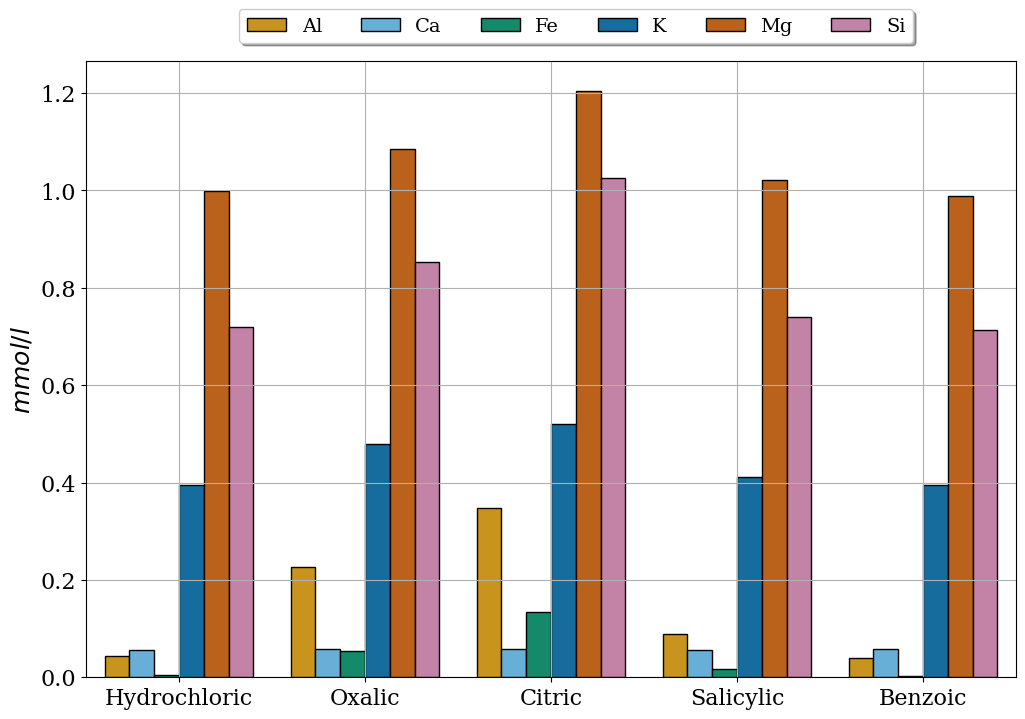

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.barplot(x='parameter', 
            y='value', 
            hue='variable', 
            data=bar_df,
            edgecolor='k',
            # capsize=.05,
            dodge=True,
            errorbar=None,
           ax=ax)
leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.9, 1.1),
               fontsize=14,  
               ncol=6,
               shadow=True,)

ax.grid()
ax.set_ylabel('$mmol/l$')

ax.set_xlabel('')
plt.savefig('../plots/barplots.png', dpi=300)
plt.show()

In [ ]:
# !mkdir ../plots/acids

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:8: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='days',
/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


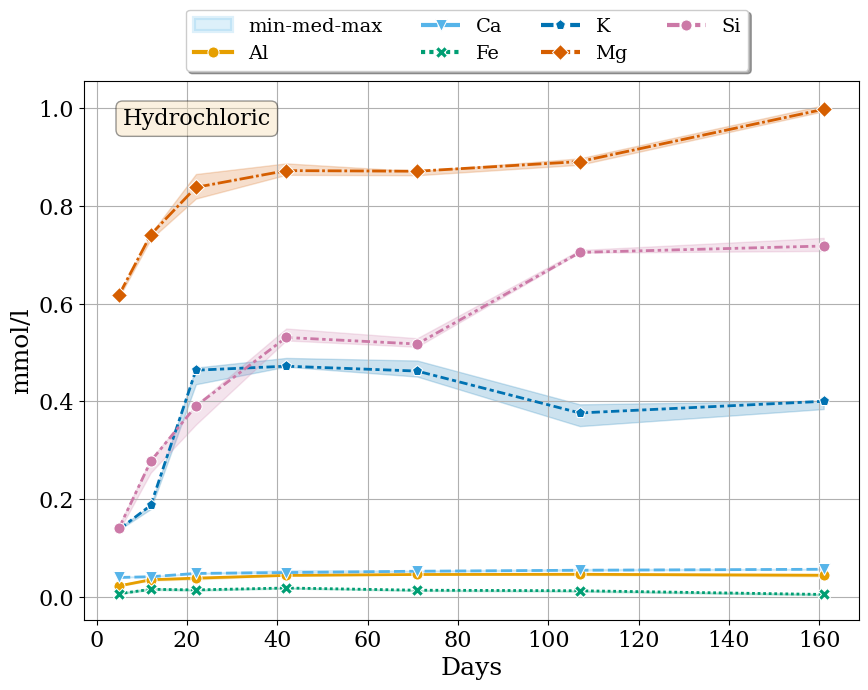

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:8: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='days',
/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


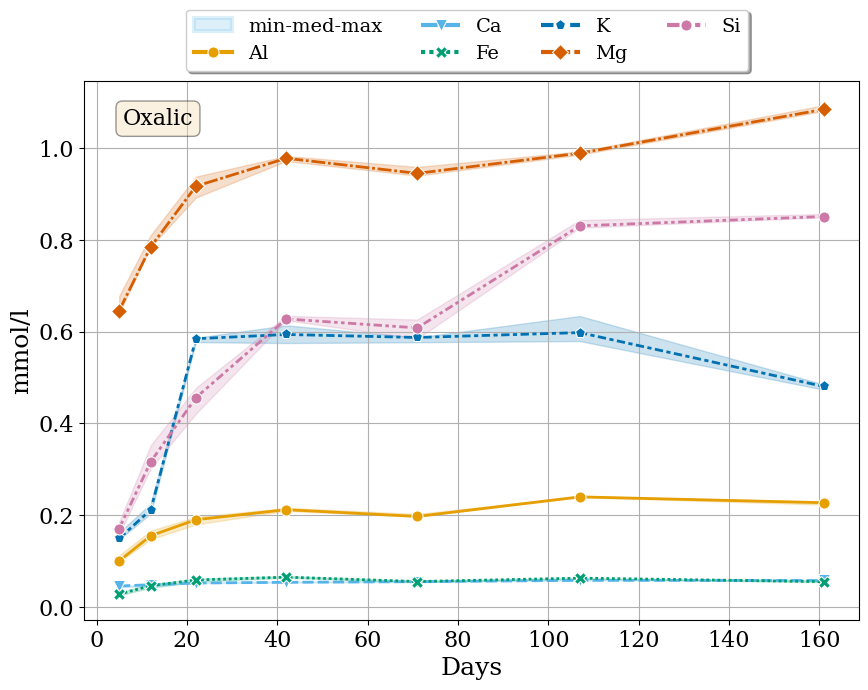

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:8: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='days',
/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


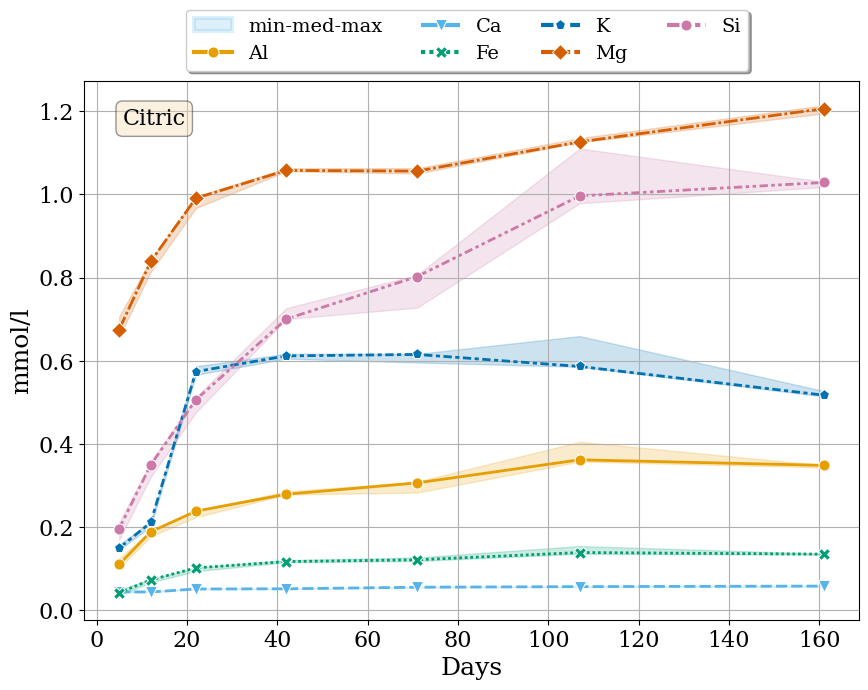

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:8: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='days',
/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


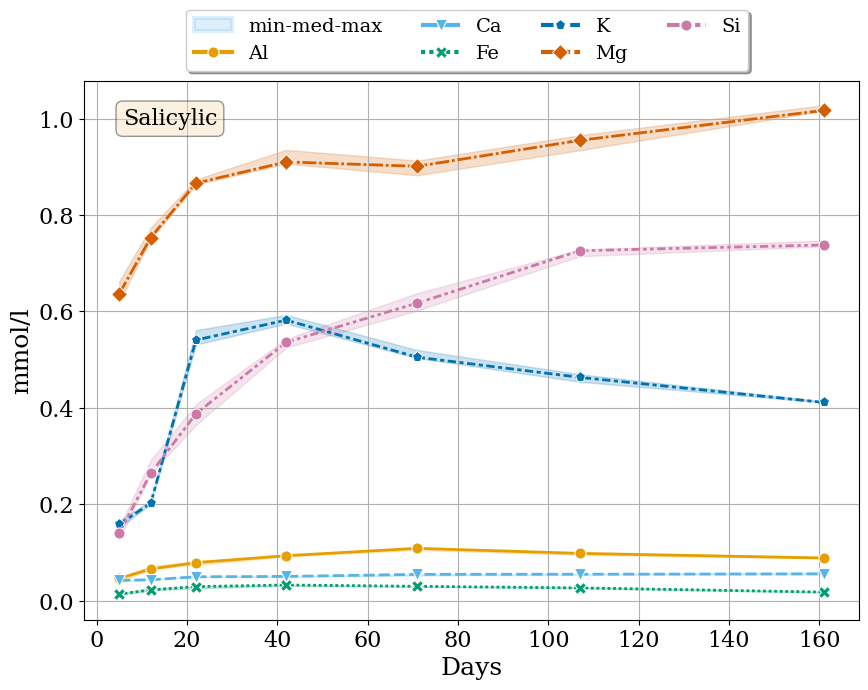

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:8: UserWarning: 
The markers list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x='days',
/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/701260225.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


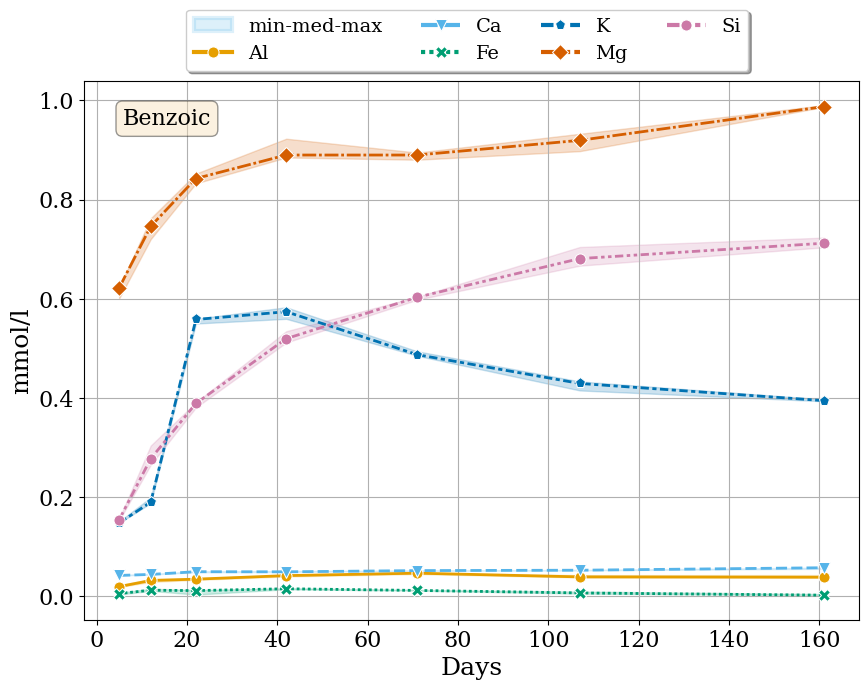

In [ ]:
folder = '../plots/acids/'
acids=['Hydrochloric', 'Oxalic', 'Citric', 'Salicylic', 'Benzoic']
for i, acid in enumerate(acids):
    mask = df_melted['parameter']==acid
    
    acid_df = df_melted.loc[mask]
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y='value',
                 markersize=8, 
                 markers=["o", "v", 'X', "p", 'D'],
                 errorbar=lambda x: (x.min(), x.max()),
                 estimator='median',
                 linewidth = 2,
                 data=acid_df, 
                 style = 'variable', 
                 hue='variable',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('min-med-max')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.87, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)
    
    ax.set_ylabel('mmol/l')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(3)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    ax.text(0.05, 0.95, acid, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    fname = os.path.join(folder, acid+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [ ]:
df_ph = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ph_ds')

dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['code', 'days', 'pH', 'RedOx', 'EC']
df_ph = df_ph[cols]

In [ ]:
df_ph=df_ph.merge(df[['parameter', 'code']], on='code', how='left')

In [ ]:
mask = df_ph['parameter'].isna()
sel = df_ph.loc[mask].index

In [ ]:
df_ph = df_ph.fillna(method='bfill')

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/2654898969.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ph = df_ph.fillna(method='bfill')


In [ ]:
df_ph.loc[:, 'RedOx'] = df_ph.loc[:, 'RedOx']+202

In [ ]:
# !mkdir ../plots/phys_chem/

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/964968520.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


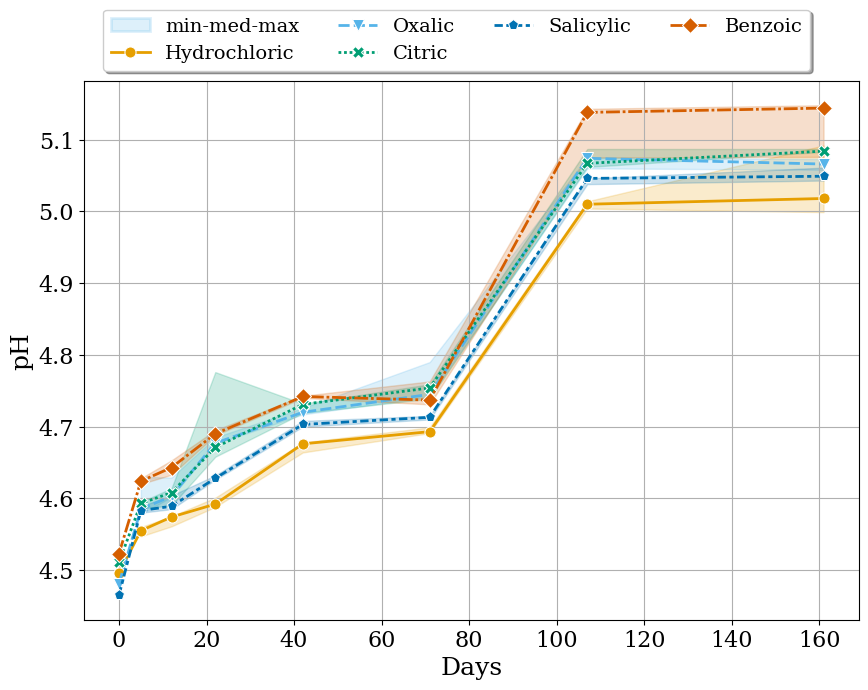

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/964968520.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


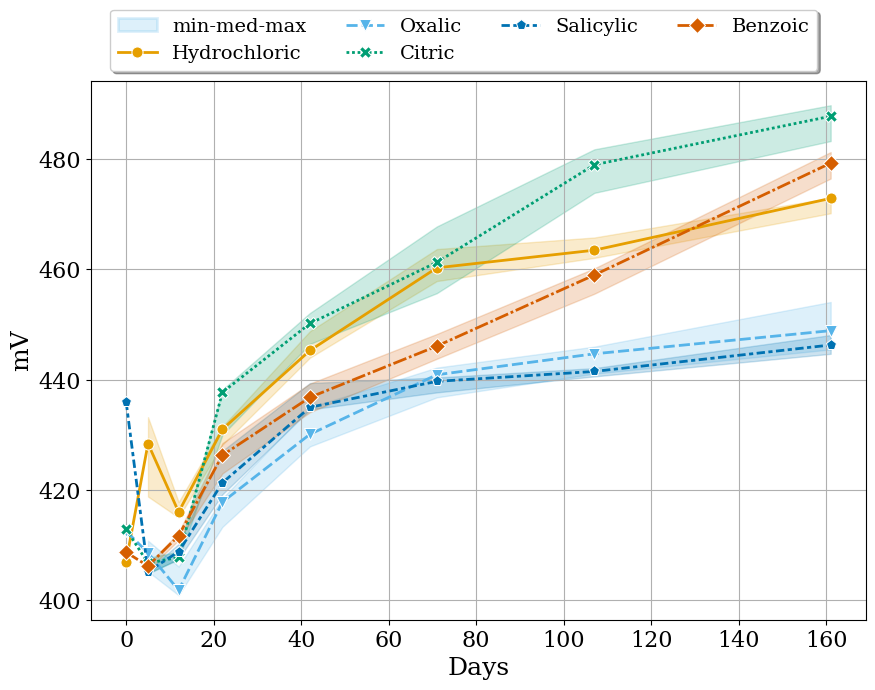

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_64601/964968520.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


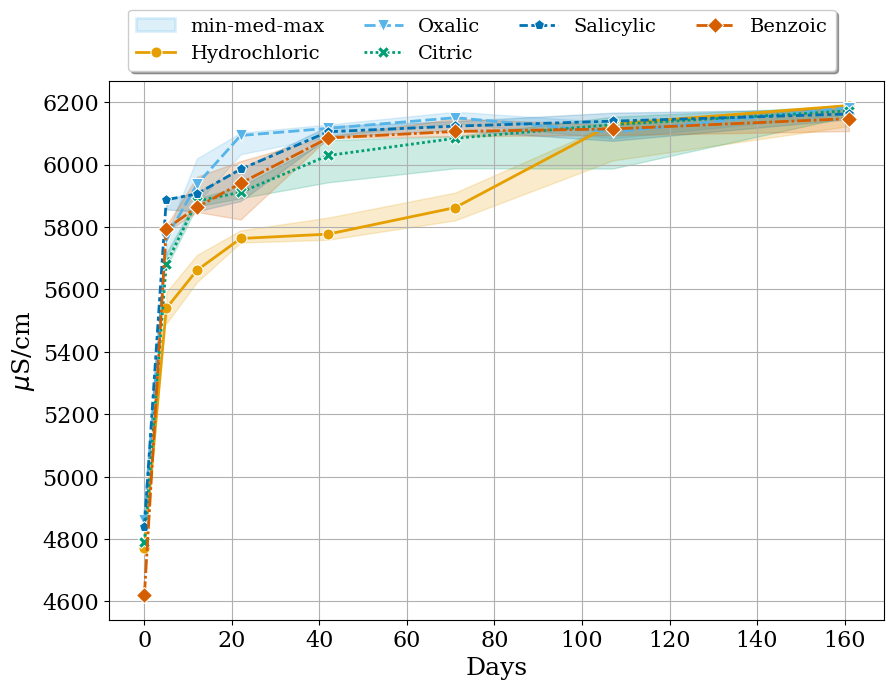

In [ ]:
folder = '../plots/phys_chem/'
units = {'pH':'pH', 
         "RedOx": "mV", 
         'EC': "${\mu}$S/cm" }
for prp in ['pH', "RedOx", 'EC']:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=prp,
                 markersize=8, 
                 markers=["o", "v", 'X', "p", 'D'],
                 errorbar=lambda x: (x.min(), x.max()),
                 estimator='median',
                 linewidth = 2,
                 data=df_ph, 
                 style = 'parameter', 
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('min-med-max')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.95, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)

    ax.set_ylabel(units[prp])
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(2)

    fname = os.path.join(folder, prp+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()


### End